In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
import nibabel as nib
import numpy.ma as ma
from numpy import savetxt
import os
#set up working directories
outDir = '/host/percy/local_raid/hans/amyg/hist/outputs/'

In [35]:
#input variables
res='100'
side='L'

In [41]:
# load mask to clean off all background data from feature data
# pick different masks depending on the cropping size
maskNif = nib.load(outDir+'amyg_'+side+'_'+res+'um_mask-bin-vF_ero5.nii.gz')
mask = np.array(maskNif.dataobj)

#turn mask into a list
maskBin = np.where(mask == 1, 0, 1)
maskBin = maskBin.tolist() 

In [42]:
#Load UMAP embeddings
nn=15
md=0.1
path = str(outDir +'/'+res+'umUMAPembeddings_'+side+'_amyg_ero5_1sd.csv')
embedding=np.loadtxt(path,delimiter=',')

In [43]:
#load all three amydala segmentations (CM) derived from julich probability maps and make matrix for 
target_file=str('prob_prctile_probsCM')
tmp = nib.load(outDir+side+'_'+res+'um_'+target_file+'.nii.gz')
CM = np.array(tmp.dataobj)

target_file=str('prob_prctile_probsLB')
tmp = nib.load(outDir+side+'_'+res+'um_'+target_file+'.nii.gz')
LB = np.array(tmp.dataobj)

target_file=str('prob_prctile_probsSF')
tmp = nib.load(outDir+side+'_'+res+'um_'+target_file+'.nii.gz')
SF = np.array(tmp.dataobj)

In [44]:
#create matrix with corresponding coordinates for each U1/2 values in order to create colormap for UMAP projections
matlen=len(mask[:,1,1])*len(mask[1,:,1])*len(mask[1,1,:])
print(matlen)
coords=np.zeros((matlen,8))
num=0
for i in range(len(mask[:,1,1])):
    for j in range(len(mask[1,:,1])):
        for k in range(len(mask[1,1,:])):
            if mask[i,j,k] == 1:
                coords[num,0] = embedding[num,0]
                coords[num,1] = embedding[num,1]
                if CM[i,j,k] != 0:       
                    coords[num,2]=CM[i,j,k]
                elif LB[i,j,k] != 0:
                    coords[num,3]=LB[i,j,k]
                elif SF[i,j,k] != 0:
                    coords[num,4]=SF[i,j,k]
                num=num+1;
                
                

10423270


In [45]:
#####don't need this unless using rgb values####
#turn all coordinate points into rbg values (scale to 1)

for c in [2,3,4]:
    #make the min value = 0 for each dimension in order to scale 
    minVal = min(coords[:,c][np.nonzero(coords[:,c])])
    for pos,val in enumerate(coords[:,c]): 
        if coords[pos,c] != 0:
            coords[pos,5] = val-minVal
            coords[pos,6] = val-minVal
            coords[pos,7] = val-minVal
    maxVal = max(coords[:,c])
    # scale values to 1
    if c == 2:
        scaleR, scaleG, scaleB = 100/maxVal, 50/maxVal, 255/maxVal 

    if c == 3:
        scaleR, scaleG, scaleB = 50/maxVal, 255/maxVal, 100/maxVal

    if c == 4:
        scaleR, scaleG, scaleB = 255/maxVal, 100/maxVal, 50/maxVal

    for pos,val in enumerate(coords[:,c]):
        if coords[pos,c] != 0:
            #divide by 255,50 and 100 to make all values RGBa instead of rgb
            coords[pos,5] = val*scaleR/255
            coords[pos,6] = val*scaleG/255
            coords[pos,7] = val*scaleB/255


In [53]:
#initialise groups for UMAP scatter plot
#divide by points in juelich maps and points outside
sd = 4
juelichpts = coords[:,0:2][np.nonzero(coords[:,sd])]
greypts = coords[:,0:2][np.nonzero(coords[:,sd] == 0)]
probs = coords[:,sd][np.nonzero(coords[:,sd])]
rgb = coords[:,5:8][np.nonzero(coords[:,sd])]
grey = coords[:,5:8][np.nonzero(coords[:,2] == 0)]

In [54]:
print(type(rgb[1,1]))

<class 'numpy.float64'>


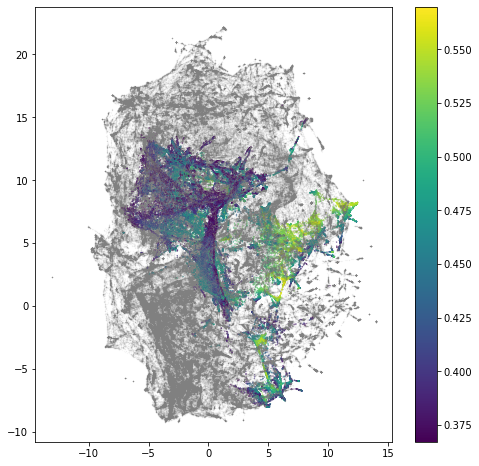

In [55]:
#project UMAP embeddings as scatter plot

plt.figure(figsize=(8,8))
plt.scatter(
    juelichpts[:, 1],
    juelichpts[:, 0],
    c = probs,
    cmap = 'viridis',
    alpha=1,
    s=.1)
plt.colorbar()
plt.scatter(
    greypts[:, 1],
    greypts[:, 0],
    color = [0.5,0.5,0.5],
    alpha=0.08,
    s=.1)
plt.show
plt.savefig(str(side+"_SF_heatmap_UMAP_"+res+"um_amyg_ero5_1sd.png"))